# Apply Algorithm to Chen's Data

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.stats import mode
from sklearn.cluster import KMeans

iterations = 20
burn_in = 10
thining = 2

## Preprocess data

In [2]:
df = pd.read_excel("data/Chen2016Data.xlsx")
df.rename(columns={df.columns[0]: 'participant_category', df.columns[1]: 'participant'}, inplace=True)
df['diseased'] = df.apply(lambda row: row.participant_category != 'CN', axis = 1)
df = pd.melt(df, id_vars=['participant_category', "participant", "timestamp", 'diseased'], 
                    value_vars=["FCI(HIP)", "GMI(HIP)", "FCI(Fusi)", "FCI(PCC)", "GMI(FUS)"], 
                    var_name='biomarker', value_name='measurement')
# convert participant id
num_participant = len(df.participant.unique())
participant_string_id_dic = dict(zip(df.participant.unique(), [_ for _ in range(num_participant)]))
df['participant'] = df.apply(lambda row: participant_string_id_dic[row.participant], axis = 1 )
data_we_have = df 
data_we_have.head()

,participant_category,participant,timestamp,diseased,biomarker,measurement
0,CN,0,6/2/2011,False,FCI(HIP),-2.544567
1,CN,1,9/2/2011,False,FCI(HIP),-1.603212
2,CN,2,10/11/2011,False,FCI(HIP),-4.716009
3,CN,3,8/8/2011,False,FCI(HIP),-4.232625
4,CN,4,11/28/2011,False,FCI(HIP),3.628361


In [3]:
## These are the healthy participants (Participant ID)
non_diseased_participants = list(set(data_we_have.loc[data_we_have.diseased == False].participant))
len(non_diseased_participants), len(set(data_we_have.participant))

(45, 144)

In [4]:
biomarkers = list(set(data_we_have.biomarker))
biomarkers

['GMI(FUS)', 'FCI(HIP)', 'FCI(Fusi)', 'FCI(PCC)', 'GMI(HIP)']

In [5]:
num_biomarkers = len(biomarkers)
num_biomarkers

5

## Get Theta and Phi Estimates Using k-means

In [6]:
def get_theta_phi(data, biomarker, kmeans_setup):
    """To get theta and phi parametesr
    Input:
        - data: data we have right now, without access to S_n and kj
        - biomarker: a string of biomarker name
    Output:
        mean and std of theta and phi
    """
    # two empty clusters to strore measurements
    clusters = [[] for _ in range(2)]
    # dataframe for this biomarker
    biomarker_df = data[data['biomarker'] == biomarker].reset_index(drop=True)
    measurements = np.array(biomarker_df['measurement'])
    # reshape to satisfy sklearn requirements
    measurements = measurements.reshape(-1, 1)
    # dataframe for non-diseased participants
    healthy_df = biomarker_df[biomarker_df['diseased'] == False]
    kmeans = kmeans_setup.fit(measurements)
    predictions = kmeans.predict(measurements)
    # to store measurements into their cluster
    for i, prediction in enumerate(predictions):
        clusters[prediction].append(measurements[i][0])
    # which cluster are healthy participants in
    healthy_predictions = kmeans.predict(measurements[healthy_df.index])
    # the mode of the above predictions will be the phi cluster index
    phi_cluster_idx = mode(healthy_predictions, keepdims=False).mode
    theta_cluster_idx = 1 - phi_cluster_idx
    theta_mean, theta_std = np.mean(clusters[theta_cluster_idx]), np.std(clusters[theta_cluster_idx])
    phi_mean, phi_std = np.mean(clusters[phi_cluster_idx]), np.std(clusters[phi_cluster_idx])
    return theta_mean, theta_std, phi_mean, phi_std

In [7]:
kmeans_setup = KMeans(n_clusters=2, random_state=0, n_init="auto")
# empty list of dictionaries to store the estimates 
means_stds_estimate_dict_list = []
for biomarker in biomarkers:
    dic = {'biomarker': biomarker}
    theta_mean, theta_std, phi_mean, phi_std = get_theta_phi(data_we_have, biomarker, kmeans_setup)
    dic['theta_mean'] = theta_mean
    dic['theta_std'] = theta_std
    dic['phi_mean'] = phi_mean
    dic['phi_std'] = phi_std
    means_stds_estimate_dict_list.append(dic)
theta_phi_kmeans = pd.DataFrame(means_stds_estimate_dict_list)

In [8]:
theta_phi_kmeans

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,GMI(FUS),0.457107,0.044667,0.569150,0.035734
1,FCI(HIP),2.794918,2.983066,-5.546734,2.887983
2,FCI(Fusi),-19.767018,4.183856,-10.216922,3.021294
3,FCI(PCC),11.583134,3.358987,1.781998,3.292063
4,GMI(HIP),0.341778,0.054571,0.482245,0.037704


## Metropolis-Hastings Algorithm Implementation Soly Dependent on Theta_Phi_Kmeans

In [9]:
def fill_up_pdata(pdata, k_j):
    '''Fill up a single participant's data using k_j; basically add two columns: 
    k_j and affected
    Note that this function assumes that pdata already has the S_n column
    
    Input:
    - pdata: a dataframe of ten biomarker values for a specific participant 
    - k_j: a scalar
    '''
    data = pdata.copy()
    data['k_j'] = k_j
    data['affected'] = data.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data 

In [10]:
def compute_single_measurement_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the measurement value of a single biomarker
    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of this given measurement value. 

    input:
    - theta_phi: the dataframe containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a scalar
    '''
    biomarker_params = theta_phi[theta_phi.biomarker == biomarker].reset_index()
    mu = biomarker_params['theta_mean'][0] if affected else biomarker_params['phi_mean'][0]
    std = biomarker_params['theta_std'][0] if affected else biomarker_params['phi_std'][0]
    var = std**2
    likelihood = np.exp(-(measurement - mu)**2/(2*var))/np.sqrt(2*np.pi*var)
    return likelihood

In [11]:
def compute_likelihood(pdata, k_j, theta_phi):
    '''This implementes the formula of https://ebm-book2.vercel.app/distributions.html#known-k-j
    This function computes the likelihood of seeing this sequence of biomarker values for a specific participant
    '''
    data = fill_up_pdata(pdata, k_j)
    likelihood = 1
    for i, row in data.iterrows():
        biomarker = row['biomarker']
        measurement = row['measurement']
        affected = row['affected']
        likelihood *= compute_single_measurement_likelihood(
            theta_phi, biomarker, affected, measurement)
    return likelihood

In [12]:
def metropolis_hastings_with_theta_phi_kmeans(
        data_we_have, iterations, theta_phi, non_diseased_participants,
        burn_in, thining, 
        ):
    '''Implement the metropolis-hastings algorithm
    Inputs: 
        - data: data_we_have
        - iterations: number of iterations

    Outputs:
        - best_order: a numpy array
        - best_likelihood: a scalar 
    '''
    num_participants = len(data_we_have.participant.unique())
    num_biomarkers = len(data_we_have.biomarker.unique())
    num_stages = num_biomarkers + 1

    all_dicts = []

    # initialize an ordering and likelihood
    # note that it should be a random permutation of numbers 1-10
    best_order = np.random.permutation(np.arange(1, num_stages))
    biomarker_names = np.array(list(data_we_have.biomarker.unique()))
    biomarker_best_order_dic = dict(zip(biomarker_names, best_order))

    best_likelihood = -np.inf

    # initialize participant_stages 
    # note that high should be num_stages; otherwise, no participants will be in the stage of 10
    participant_stages = np.random.randint(low = 0, high = num_stages, size = num_participants)
    participant_stages[non_diseased_participants] = 0

    for _ in range(iterations):
        new_order = best_order.copy()
        # randomly select two indices
        a, b = np.random.choice(num_biomarkers, 2, replace=False)
        # swapping the order
        new_order[a], new_order[b] = new_order[b], new_order[a]
        # biomarker - order dict
        ordering_dic = dict(zip(biomarker_names, new_order))
        # fill up S_n column using the ordering dict
        # copy first in order not to change data_we_have
        data = data_we_have.copy()
        # now data_we_have has S_n column
        data['S_n'] = data.apply(lambda row: ordering_dic[row['biomarker']], axis = 1)

        all_participant_ln_likelihood = 0 
        for p in range(num_participants):
            # copy participant_stages 
            participant_stages_copy = participant_stages.copy()
            # this participant data
            pdata = data[data.participant == p].reset_index(drop=True)

            """If this participant is not diseased (i.e., if we know k_j is equal to 0)
            We still need to compute the likelihood of this participant seeing this sequence of biomarker data
            but we do not need to estimate k_j like below

            We still need to compute the likelihood because we need to add it to all_participant_ln_likelihood
            """
            if p in non_diseased_participants:
                # the following will update pdata's kj and affect columns
                this_participant_likelihood = compute_likelihood(
                    pdata, k_j = 0, theta_phi = theta_phi)
                this_participant_ln_likelihood = np.log(this_participant_likelihood)
            else:
                # initiaze stage_likelihood
                stage_likelihood = np.zeros(num_stages)
                for k_j in range(num_stages):
                    # even though data above has everything, it is filled up by random stages
                    # we don't like it and want to know the true k_j. All the following is to update participant_stages

                    # likelihood for this participant to have this specific sequence of biomarker values
                    participant_likelihood = compute_likelihood(pdata, k_j, theta_phi)

                    # update each stage likelihood for this participant
                    stage_likelihood[k_j] = participant_likelihood
                likelihood_sum = np.sum(stage_likelihood)
                normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
                sampled_stage = np.random.choice(np.arange(num_stages), p = normalized_stage_likelihood)
                participant_stages_copy[p] = sampled_stage   

                # if participant is at sample_stage, 
                # what is the likelihood of this participant having this sequence of biomarker data:
                this_participant_likelihood =  stage_likelihood[sampled_stage]

                # then, update all_participant_likelihood
                if this_participant_likelihood == 0:
                    this_participant_ln_likelihood = np.log(this_participant_likelihood + 1e20)
                else:
                    this_participant_ln_likelihood = np.log(this_participant_likelihood)
            """
            All the codes in between are calculating this_participant_ln_likelihood. If we already know kj=0, then
            it's very simple. If kj is unknown, we need to calculate the likelihood of seeing this sequence of biomarker
            data at different stages, and get the relative likelihood before we get a sampled stage. Then we calculate
            this_participant_ln_likelihood again. 
            """
            all_participant_ln_likelihood += this_participant_ln_likelihood
            
        """
        The key to both `metropolis_hastings_with_theta_phi_kmeans` and `metropolis_hastings` is to 
        compare best_likelihood and the likelihood of all participants having specific sequences of measurements
        based on the assumed S_n. 

        The difference lies in how to calculate all_participant_ln_likelihood. 

        `metropolis_hastings_with_theta_phi_kmeans` tries to obtain k_j and calculate each likelihood exactly 
        whereas `metropolis_hastings` did not obtain exact k_j and calculate the average likelihood instead
        """
        acceptance_ratio = np.exp(all_participant_ln_likelihood - best_likelihood)
        random_number = np.random.rand()
        if random_number < acceptance_ratio:
            best_likelihood = all_participant_ln_likelihood
            biomarker_best_order_dic = ordering_dic
            participant_stages = participant_stages_copy
        
        if _ >= burn_in and _ % thining == 0:
            all_dicts.append(ordering_dic)

        if (_+1) % 10 == 0:
            print(f"iteration {_ + 1} done")
    return biomarker_best_order_dic, participant_stages, all_dicts

In [13]:
biomarker_best_order_dic, participant_stages, all_dicts = metropolis_hastings_with_theta_phi_kmeans(
    data_we_have, iterations, theta_phi = theta_phi_kmeans, 
    non_diseased_participants = non_diseased_participants,
    burn_in = burn_in, thining = thining, )

iteration 10 done


iteration 20 done


In [14]:
def get_biomarker_stage_probability(df, num_biomarkers):
    # Create an empty list to hold dictionaries
    dict_list = []

    # for each biomarker
    for col in df.columns:
        dic = {"biomarker": col}
        # get the frequency of biomarkers
        stage_counts = df[col].value_counts()
        # for each stage
        for i in range(1, num_biomarkers + 1):
            # get stage:prabability
            dic[i] = stage_counts.get(i, 0)/len(df)
        dict_list.append(dic)

    dff = pd.DataFrame(dict_list)
    dff.set_index(dff.columns[0], inplace=True)
    return dff 

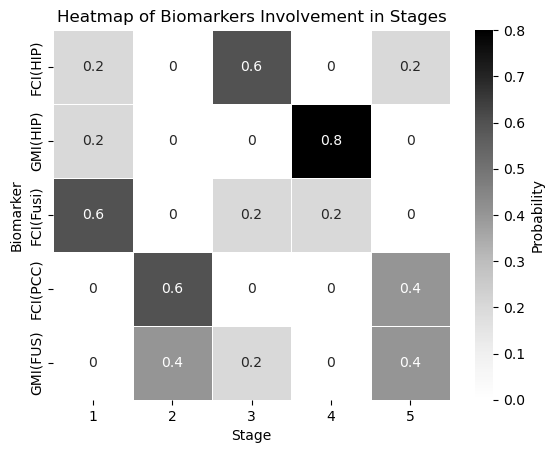

In [15]:
df = pd.DataFrame(all_dicts)
biomarker_stage_probability_df = get_biomarker_stage_probability(df, num_biomarkers)
sns.heatmap(biomarker_stage_probability_df, annot=True, cmap="Greys", linewidths=.5, cbar_kws={'label': 'Probability'})
plt.xlabel('Stage')
plt.ylabel('Biomarker')
plt.title('Heatmap of Biomarkers Involvement in Stages')
plt.show()

## Estimate Theta and Phi Based on Conjugate Priors

In [16]:
def estimate_params_exact(m0, n0, s0_sq, v0, data):
    '''This is to estimate means and vars based on conjugate priors
    Inputs:
        - data: a vector of measurements 
        - m0: prior estimate of $\mu$.
        - n0: how strongly is the prior belief in $m_0$ is held.
        - s0_sq: prior estimate of $\sigma^2$.
        - v0: prior degress of freedome, influencing the certainty of $s_0^2$.
    
    Outputs:
        - mu estiate, std estimate
    '''
    # Data summary
    sample_mean = np.mean(data)
    sample_size = len(data)
    sample_var = np.var(data, ddof=1)  # ddof=1 for unbiased estimator

    # Update hyperparameters for the Normal-Inverse Gamma posterior
    updated_m0 = (n0 * m0 + sample_size * sample_mean) / (n0 + sample_size)
    updated_n0 = n0 + sample_size
    updated_v0 = v0 + sample_size 
    updated_s0_sq = (1 / updated_v0) * ((sample_size - 1) * sample_var + v0 * s0_sq + 
                    (n0 * sample_size / updated_n0) * (sample_mean - m0)**2)
    updated_alpha = updated_v0/2
    updated_beta = updated_v0*updated_s0_sq/2

    # Posterior estimates
    mu_posterior_mean = updated_m0
    sigma_squared_posterior_mean = updated_beta/updated_alpha

    mu_estimation = mu_posterior_mean
    std_estimation = np.sqrt(sigma_squared_posterior_mean)

    return mu_estimation, std_estimation

In [17]:
def get_estimated_means_stds_df(biomarkers, data_we_have, theta_phi_kmeans):
    '''To get estimated parameters, returns a Pandas DataFrame
    Input:
    - biomarkers: biomarkers 
    - data_we_have: participants data filled with initial or updated participant_stages

    Output: 
    - estimate_means_std_df, just like means_stds_df, containing the estimated mean and std_dev for 
      distribution of biomarker values when the biomarker is affected and not affected

    Note that, there is one bug we need to fix: Sometimes, data_full might have only one observation or no ob
    '''
     # empty list of dictionaries to store the estimates 
    means_stds_estimate_dict_list = []
    
    for biomarker in biomarkers: 
        dic = {'biomarker': biomarker}  # Initialize dictionary outside the inner loop
        for affected in [True, False]:
            data_full = data_we_have[(data_we_have.biomarker == biomarker) & (
            data_we_have.affected == affected)]
            if len(data_full) > 1:
                measurements = data_full.measurement
                mu_estimate, std_estimate = estimate_params_exact(
                    m0 = 0, n0 = 1, s0_sq = 1, v0 = 1, data=measurements)
                if affected:
                    dic['theta_mean'] = mu_estimate
                    dic['theta_std'] = std_estimate
                else:
                    dic['phi_mean'] = mu_estimate
                    dic['phi_std'] = std_estimate
            # If there is only one observation or not observation at all, resort to theta_phi_kmeans
            # YES, IT IS POSSIBLE THAT DATA_FULL HERE IS NULL
            # For example, if a biomarker indicates stage of (num_biomarkers), but all participants' stages
            # are smaller than that stage; so that for all participants, this biomarker is not affected
            else:
                # DONT FORGTE RESET_INDEX; this because you are acessing [0]
                theta_phi_kmeans_biomarker_row = theta_phi_kmeans[
                    theta_phi_kmeans.biomarker == biomarker].reset_index(drop=True)
                if affected:
                    dic['theta_mean'] = theta_phi_kmeans_biomarker_row['theta_mean'][0]
                    dic['theta_std'] = theta_phi_kmeans_biomarker_row['theta_std'][0]
                else:
                    dic['phi_mean'] = theta_phi_kmeans_biomarker_row['phi_mean'][0]
                    dic['phi_std'] = theta_phi_kmeans_biomarker_row['phi_std'][0]
        # print(f"biomarker {biomarker} done!")
        means_stds_estimate_dict_list.append(dic)
    estimate_means_stds_df = pd.DataFrame(means_stds_estimate_dict_list)
    return estimate_means_stds_df 

In [18]:
def add_kj_and_affected(data_we_have, participant_stages, num_participants):
    '''This is to fill up data_we_have. 
    Basically, add two columns: k_j, and affected, based on the initial or updated participant_stages
    Note that we assume here we've already got S_n

    Inputs:
        - data_we_have
        - participant_stages: np array 
        - participants: 0-99
    '''
    participant_stage_dic = dict(zip(np.arange(0, num_participants), participant_stages))
    data_we_have['k_j'] = data_we_have.apply(lambda row: participant_stage_dic[row.participant], axis = 1)
    data_we_have['affected'] = data_we_have.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data_we_have 

In [19]:
def metropolis_hastings_unknown_theta_phi(
        data_we_have, iterations, non_diseased_participants, burn_in, thining, theta_phi_kmeans):
    num_participants = len(data_we_have.participant.unique())
    num_biomarkers = len(data_we_have.biomarker.unique())
    biomarker_names = np.array(list(data_we_have.biomarker.unique()))

    all_dicts = []

    # initialize an ordering and likelihood
    # note that it should be a random permutation of numbers 1-10
    best_order = np.random.permutation(np.arange(1, num_biomarkers+1))
    biomarker_best_order_dic = dict(zip(biomarker_names, best_order))
    best_likelihood = -np.inf 

    # initialize participant_stages 
    # note that high should be num_biomarkers + 1; otherwise, no participants will be in the stage of 10
    participant_stages = np.random.randint(low = 0, high = num_biomarkers + 1, size = num_participants)
    participant_stages[non_diseased_participants] = 0

    for _ in range(iterations):
        participant_stages_copy = participant_stages.copy()
        # when we update best_order below,
        # in each iteration, new_order will also update
        new_order = best_order.copy()
        # randomly select two indices
        a, b = np.random.choice(num_biomarkers, 2, replace=False)
        # swaping the order
        new_order[a], new_order[b] = new_order[b], new_order[a]

        # likelihood of seeing all participants' data 
        # biomarker - order dict
        ordering_dic = dict(zip(biomarker_names, new_order))
        # fill up S_n column using the ordering dict
        # copy first in order not to change data_we_have
        data = data_we_have.copy()
        # now data_we_have has S_n column
        data['S_n'] = data.apply(lambda row: ordering_dic[row['biomarker']], axis = 1)

        # add kj and affected based on the initial randomized participant_stages
        data = add_kj_and_affected(data, participant_stages_copy, num_participants)
        # print(data.head())

        # get estimated_theta_phi
        estimated_theta_phi = get_estimated_means_stds_df(biomarker_names, data_we_have=data, theta_phi_kmeans=theta_phi_kmeans)

        all_participant_ln_likelihood = 0 
        for p in range(num_participants):
            # this participant data
            pdata = data[data.participant == p].reset_index(drop=True)

            """If this participant is not diseased (i.e., if we know k_j is equal to 0)
            We still need to compute the likelihood of this participant seeing this sequence of biomarker data
            but we do not need to estimate k_j like below

            We still need to compute the likelihood because we need to add it to all_participant_ln_likelihood
            """
            if p in non_diseased_participants:
                this_participant_likelihood = compute_likelihood(
                    pdata, k_j = 0, theta_phi = estimated_theta_phi)
                this_participant_ln_likelihood = np.log(this_participant_likelihood)
            else:
                # initiaze stage_likelihood
                stage_likelihood = np.zeros(num_biomarkers + 1)
                for k_j in range(num_biomarkers +1):
                    # even though data above has everything, it is filled up by random stages
                    # we don't like it and want to know the true k_j. All the following is to update participant_stages

                    # likelihood for this participant to have this specific sequence of biomarker values
                    participant_likelihood = compute_likelihood(pdata, k_j, estimated_theta_phi)

                    # update each stage likelihood for this participant
                    stage_likelihood[k_j] = participant_likelihood
                likelihood_sum = np.sum(stage_likelihood)
                normalized_stage_likelihood = [l/likelihood_sum for l in stage_likelihood]
                sampled_stage = np.random.choice(np.arange(num_biomarkers + 1), p = normalized_stage_likelihood)
                participant_stages_copy[p] = sampled_stage   

                # if participant is in sampled_stage, what is the likelihood of seeing this sequence of biomarker data:
                this_participant_likelihood =  stage_likelihood[sampled_stage]

                # then, update all_participant_likelihood
                if this_participant_likelihood == 0:
                    this_participant_ln_likelihood = np.log(this_participant_likelihood + 1e20)
                else:
                    this_participant_ln_likelihood = np.log(this_participant_likelihood)
            all_participant_ln_likelihood += this_participant_ln_likelihood
            
        acceptance_ratio = np.exp(all_participant_ln_likelihood - best_likelihood)
        random_number = np.random.rand()
        if random_number < acceptance_ratio:
            best_likelihood = all_participant_ln_likelihood
            biomarker_best_order_dic = ordering_dic
            participant_stages = participant_stages_copy
        
        if _ >= burn_in and _ % thining == 0:
            all_dicts.append(ordering_dic)

        if (_+1) % 10 == 0:
            print(f"iteration {_ + 1} done")
    return biomarker_best_order_dic, participant_stages, all_dicts

In [20]:
data_we_have.head()

,participant_category,participant,timestamp,diseased,biomarker,measurement
0,CN,0,6/2/2011,False,FCI(HIP),-2.544567
1,CN,1,9/2/2011,False,FCI(HIP),-1.603212
2,CN,2,10/11/2011,False,FCI(HIP),-4.716009
3,CN,3,8/8/2011,False,FCI(HIP),-4.232625
4,CN,4,11/28/2011,False,FCI(HIP),3.628361


In [21]:
biomarker_best_order_dic, participant_stages, all_dicts = metropolis_hastings_unknown_theta_phi(
    data_we_have, iterations, non_diseased_participants, 
    burn_in, thining, theta_phi_kmeans)

iteration 10 done


iteration 20 done


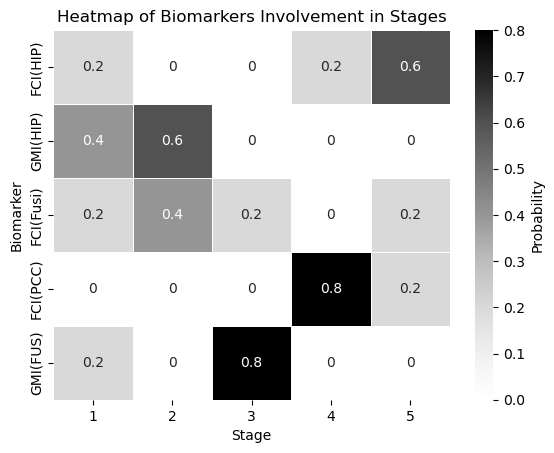

In [22]:
df = pd.DataFrame(all_dicts)
biomarker_stage_probability_df = get_biomarker_stage_probability(df, num_biomarkers)
sns.heatmap(biomarker_stage_probability_df, annot=True, cmap="Greys", linewidths=.5, cbar_kws={'label': 'Probability'})
plt.xlabel('Stage')
plt.ylabel('Biomarker')
plt.title('Heatmap of Biomarkers Involvement in Stages')
plt.show()

## Use Average Likelihood and Without Having to Estimate Each Participange Stage

In [23]:
def average_all_likelihood(pdata, num_biomarkers, theta_phi):
    '''This is to compute https://ebm-book2.vercel.app/distributions.html#unknown-k-j
    '''
    return np.mean([compute_likelihood(pdata=pdata, k_j=x, theta_phi=theta_phi) for x in range(num_biomarkers+1)])

In [24]:
def compute_ln_likelihood_assuming_ordering(ordering_dic, data, num_participants, num_biomarkers, theta_phi):
    """Compute the (ln version of) the likelihood of seeing all participants' data,
    assuming that we already know the ordering
    Inputs:
        - ordering: an array of ordering for biomarker 0-9
        - data: data_we_have
        - num_participants
        - num_biomarkers 
    Outputs:
        - ln(likelihood)
    """
    # fill up S_n column using the ordering dict
    # copy first in order not to change data_we_have
    filled_data = data.copy()
    filled_data['S_n'] = filled_data.apply(lambda row: ordering_dic[row['biomarker']], axis = 1)
    ln_likelihood = 0 
    for p in range(num_participants):
        pdata = filled_data[filled_data.participant == p].reset_index(drop=True)
        average_likelihood = average_all_likelihood(pdata, num_biomarkers, theta_phi)
        p_ln_likelihood = (
            # natural logarithm
           np.log(average_likelihood) 
           if average_likelihood > 0
           # this is to avoid np.log(0)
           else np.log(average_likelihood + 1e-20)
        )
        ln_likelihood += p_ln_likelihood
    return ln_likelihood

A brush up on log:

$L = P1 \cdot P2 \cdot P3$

$\ln(L) = \ln (P1 \cdot P2 \cdot P3) = \ln(P1) + \ln(P2) + \ln(P3)$

In [25]:
def metropolis_hastings_average_likelihood(data, iterations, burn_in, thining, theta_phi):
    '''Implement the metropolis-hastings algorithm
    Inputs: 
        - data: data_we_have
        - iterations: number of iterations

    Outputs:
        - best_order: a numpy array
        - best_likelihood: a scalar 
    '''
    num_participants = len(data.participant.unique())
    num_biomarkers = len(data.biomarker.unique())

    all_dicts = []

    # initialize an ordering and likelihood
    # note that it should be a random permutation of numbers 1-10
    best_order = np.random.permutation(np.arange(1, num_biomarkers+1))
    biomarker_names = np.array(list(data.biomarker.unique()))
    biomarker_best_order_dic = dict(zip(biomarker_names, best_order))

    best_likelihood = -np.inf 
    # best_order = np.array(list(real_ordering_dic.values()))
    # best_likelihood = compute_likelihood_based_on_ordering(
    #     best_order, data, num_participants, num_biomarkers, theta_phi
    # )
    for _ in range(iterations):
        new_order = best_order.copy()
        # randomly select two indices
        a, b = np.random.choice(num_biomarkers, 2, replace=False)
        # swapping the order
        new_order[a], new_order[b] = new_order[b], new_order[a]
        biomarker_new_order_dic = dict(zip(biomarker_names, new_order))
        ln_likelihood = compute_ln_likelihood_assuming_ordering(
            biomarker_new_order_dic, data, num_participants, num_biomarkers, theta_phi)
        # if swapping results in higher likelihood, 
        # update the likelihood and accept the new ordering 
        if ln_likelihood > best_likelihood:
            best_likelihood = ln_likelihood 
            biomarker_best_order_dic = biomarker_new_order_dic
        else: 
            # ratio = likelihood/best_likelihood
            # np.exp(a - b) = np.exp(a)/np.exp(b)
            acceptance_ratio = np.exp(ln_likelihood - best_likelihood)
            random_number = np.random.rand()
            if random_number < acceptance_ratio:
                best_likelihood = ln_likelihood
                biomarker_best_order_dic = biomarker_new_order_dic

        if _ >= burn_in and _ % thining == 0:
            all_dicts.append(biomarker_new_order_dic)
        
        if (_+1) % 10 == 0:
            print(f"iteration {_ + 1} done")

    return biomarker_best_order_dic, best_likelihood, all_dicts

In [26]:
biomarker_best_order_dic, best_likelihood, all_dicts = metropolis_hastings_average_likelihood(
    data_we_have, iterations, burn_in, thining, theta_phi = theta_phi_kmeans)

iteration 10 done


iteration 20 done


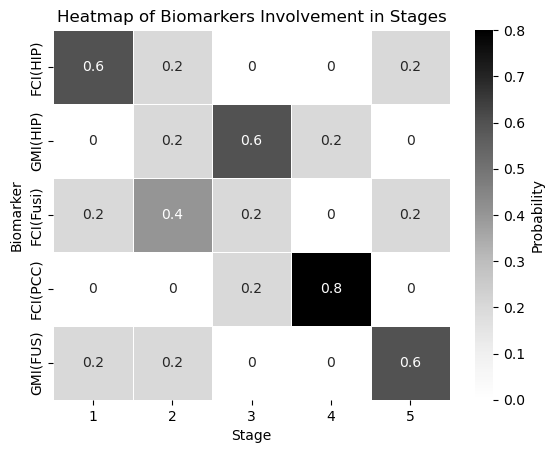

In [27]:
df = pd.DataFrame(all_dicts)
biomarker_stage_probability_df = get_biomarker_stage_probability(df, num_biomarkers)
sns.heatmap(biomarker_stage_probability_df, annot=True, cmap="Greys", linewidths=.5, cbar_kws={'label': 'Probability'})
plt.xlabel('Stage')
plt.ylabel('Biomarker')
plt.title('Heatmap of Biomarkers Involvement in Stages')
plt.show()